# Assignment 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calplot
import scipy.stats as stats
import folium
from folium.plugins import HeatMapWithTime

## Data Wrangling

In [2]:
# Load data

path1 = "/Users/markusswegmark/Desktop/Visualization/Police_Department_Incident_Reports__Historical_2003_to_May_2018_20250204.csv"
path2 = "/Users/markusswegmark/Desktop/Visualization/Police_Department_Incident_Reports__2018_to_Present_20250204.csv"

df_2003 = pd.read_csv(
    path1,
    sep=',')  
df_2018 = pd.read_csv(
    path2,
    sep=',')  

Add "year" column to first dataset

In [3]:
df_2003["year"] = df_2003["Date"].str.extract(r'(\d{4})$').astype(int)

### Merge datasets

First we investigate the categeories in the two datasets

In [4]:
# Print column names for both datasets
print("Columns in df1:")
print(df_2003.columns.tolist())

print("\nColumns in df2:")
print(df_2018.columns.tolist())

# Print unique categories for both datasets
print("\nUnique categories in df1:")
print(df_2003['Category'].unique())

print("\nUnique categories in df2:")
print(df_2018['Incident Category'].unique())

print("\nUnique subcategories in df2:")
print(df_2018['Incident Subcategory'].unique())

Columns in df1:
['PdId', 'IncidntNum', 'Incident Code', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'location', 'SF Find Neighborhoods 2 2', 'Current Police Districts 2 2', 'Current Supervisor Districts 2 2', 'Analysis Neighborhoods 2 2', 'DELETE - Fire Prevention Districts 2 2', 'DELETE - Police Districts 2 2', 'DELETE - Supervisor Districts 2 2', 'DELETE - Zip Codes 2 2', 'DELETE - Neighborhoods 2 2', 'DELETE - 2017 Fix It Zones 2 2', 'Civic Center Harm Reduction Project Boundary 2 2', 'Fix It Zones as of 2017-11-06  2 2', 'DELETE - HSOC Zones 2 2', 'Fix It Zones as of 2018-02-07 2 2', 'CBD, BID and GBD Boundaries as of 2017 2 2', 'Areas of Vulnerability, 2016 2 2', 'Central Market/Tenderloin Boundary 2 2', 'Central Market/Tenderloin Boundary Polygon - Updated 2 2', 'HSOC Zones as of 2018-06-05 2 2', 'OWED Public Spaces 2 2', 'Neighborhoods 2', 'year']

Columns in df2:
['Incident Datetime', 'Incident Date', 'Incident Time', 'I

Now mergeing the datasets based on the catageries that seem to relate

In [17]:
# Load datasets
df1 = df_2003
df2 = df_2018

# Define column mapping for df1, including x and y
column_mapping = {
    'IncidntNum': 'IncidentNumber',
    'Incident Code': 'IncidentCode',
    'Category': 'Category',
    'Descript': 'Subcategory', 
    'Date': 'Date',
    'Time': 'Time',
    'PdDistrict': 'PoliceDistrict',
    'Resolution': 'Resolution',
    'year': 'Year',
    'X': 'Longitude',   
    'Y': 'Latitude'     
}

# Select and rename columns in df1
df1 = df1[list(column_mapping.keys())].rename(columns=column_mapping)

# Select and rename columns in df2 (adding Latitude, Longitude to the list)
df2 = df2[['Incident Number', 'Incident Code', 'Incident Category', 'Incident Subcategory', 
           'Incident Date', 'Incident Time', 'Police District', 'Resolution', 'Incident Year',
           'Latitude', 'Longitude']]
df2.columns = ['IncidentNumber', 'IncidentCode', 'Category', 'Subcategory', 'Date', 
               'Time', 'PoliceDistrict', 'Resolution', 'Year', 'Latitude', 'Longitude']

df1 = df1.apply(lambda x: x.str.upper() if x.dtype == "object" else x)
df2 = df2.apply(lambda x: x.str.upper() if x.dtype == "object" else x)

# Define the category mapping
category_mapping = {
    "LARCENY/THEFT": {"Category": ["LARCENY THEFT"], "Subcategory": ["LARCENY THEFT - OTHER", "LARCENY - FROM VEHICLE", "LARCENY THEFT - BICYCLE", "LARCENY THEFT - SHOPLIFTING", "LARCENY THEFT - FROM BUILDING", "LARCENY THEFT - PICKPOCKET", "LARCENY - AUTO PARTS", "LARCENY THEFT - PURSE SNATCH"]},
    "VEHICLE THEFT": {"Category": ["MOTOR VEHICLE THEFT"], "Subcategory": ["MOTOR VEHICLE THEFT (ATTEMPTED)"]},
    "STOLEN PROPERTY": {"Category": ["STOLEN PROPERTY"], "Subcategory": []},
    "DRUG/NARCOTIC": {"Category": ["DRUG VIOLATION", "DRUG OFFENSE"], "Subcategory": []},
    "ASSAULT": {"Category": ["ASSAULT"], "Subcategory": ["SIMPLE ASSAULT", "AGGRAVATED ASSAULT"]},
    "ROBBERY": {"Category": ["ROBBERY"], "Subcategory": ["ROBBERY - CARJACKING", "ROBBERY - OTHER", "ROBBERY - COMMERCIAL", "ROBBERY - STREET", "ROBBERY - RESIDENTIAL"]},
    "BURGLARY": {"Category": ["BURGLARY"], "Subcategory": ["BURGLARY - OTHER", "BURGLARY - COMMERCIAL", "BURGLARY - RESIDENTIAL", "BURGLARY - HOT PROWL"]},
    "VANDALISM": {"Category": ["VANDALISM", "MALICIOUS MISCHIEF"], "Subcategory": []},
    "WEAPON LAWS": {"Category": ["WEAPONS CARRYING ETC", "WEAPONS OFFENSE", "WEAPONS OFFENCE"], "Subcategory": []},
    "SEX OFFENSES, FORCIBLE": {"Category": ["RAPE"], "Subcategory": ["RAPE - ATTEMPTED"]},
    "SEX OFFENSES, NON FORCIBLE": {"Category": ["SEX OFFENSE"], "Subcategory": []},
    "PROSTITUTION": {"Category": ["PROSTITUTION"], "Subcategory": []},
    "DRIVING UNDER THE INFLUENCE": {"Category": ["TRAFFIC VIOLATION ARREST"], "Subcategory": []},
    "KIDNAPPING": {"Category": ["KIDNAPPING"], "Subcategory": []},
    "EXTORTION": {"Category": ["EXTORTION-BLACKMAIL"], "Subcategory": []},
    "GAMBLING": {"Category": ["GAMBLING"], "Subcategory": []},
    "BRIBERY": {"Category": ["BRIBERY"], "Subcategory": []},
    "FRAUD/FINANCIAL CRIME": {"Category": ["FRAUD", "FORGERY AND COUNTERFEITING", "BAD CHECKS", "EMBEZZLEMENT"], "Subcategory": []},
    "LOITERING": {"Category": ["LOITERING"], "Subcategory": []},
    "DRUNKENNESS": {"Category": ["LIQUOR LAWS"], "Subcategory": ["LIQUOR LAW VIOLATION"]},
    "DISORDERLY CONDUCT": {"Category": ["DISORDERLY CONDUCT"], "Subcategory": []},
    "TRESPASS": {"Category": ["SUSPICIOUS OCC", "SUSPICIOUS"], "Subcategory": ["TRESPASS"]},
    "HOMICIDE": {"Category": ["HOMICIDE"], "Subcategory": ["MANSLAUGHTER", "HOMICIDE - EXCUSABLE"]},
    "SUICIDE": {"Category": ["SUICIDE"], "Subcategory": []},
    "MISSING PERSON": {"Category": ["MISSING PERSON"], "Subcategory": ["MISSING ADULT"]},
    "TRAFFIC INCIDENT": {"Category": ["TRAFFIC COLLISION"], "Subcategory": ["TRAFFIC COLLISION - HIT & RUN"]},
    "HUMAN TRAFFICKING": {"Category": ["HUMAN TRAFFICKING, COMMERCIAL SEX ACTS", "HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS", "HUMAN TRAFFICKING (B), INVOLUNTARY SERVITUDE", "HUMAN TRAFFICKING, INVOLUNTARY SERVITUDE"], "Subcategory": []},
    "OFFENSES AGAINST FAMILY & CHILDREN": {"Category": ["OFFENCES AGAINST THE FAMILY AND CHILDREN"], "Subcategory": []},
    "OTHER OFFENSES": {"Category": ["OTHER OFFENSES", "OTHER", "OTHER MISCELLANEOUS", "CASE CLOSURE", "CIVIL SIDEWALKS"], "Subcategory": []},
    "NON-CRIMINAL": {"Category": ["NON-CRIMINAL"], "Subcategory": ["COURTESY REPORT"]},
}

# Function to clean and map categories
def map_category(row):
    category = row['Category'].upper().strip() if pd.notna(row['Category']) else ""
    subcategory = row['Subcategory'].upper().strip() if pd.notna(row['Subcategory']) else ""

    for target, mapping in category_mapping.items():
        if category in mapping["Category"] or subcategory in mapping["Subcategory"]:
            return target
    
    return category if category else "UNKNOWN"

# Apply category mapping to both datasets
df1['Category'] = df1.apply(map_category, axis=1)
df2['Category'] = df2.apply(map_category, axis=1)

# Ensure 'Date' is in datetime format
df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')
df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')

# Merge datasets
df = pd.concat([df1, df2], ignore_index=True).dropna()

# Drop duplicated
df = df.drop_duplicates(subset=['IncidentNumber', 'Date'])

# Remove year 2025 since it's not complete
df = df[df['Year'] != 2025]

## Investigate drug crimes

In [24]:
# Filter only PROSTITUTION crimes
df_drugs = df[df['Category'] == 'DRUG/NARCOTIC'].copy()

# Remove rows with invalid lat/long (e.g., missing, 0, or out of SF range)
df_drugs = df_drugs.dropna(subset=['Latitude', 'Longitude'])
df_drugs = df_drugs[(df_drugs['Latitude'].between(37.70, 37.85)) & 
                  (df_drugs['Longitude'].between(-122.53, -122.35))]

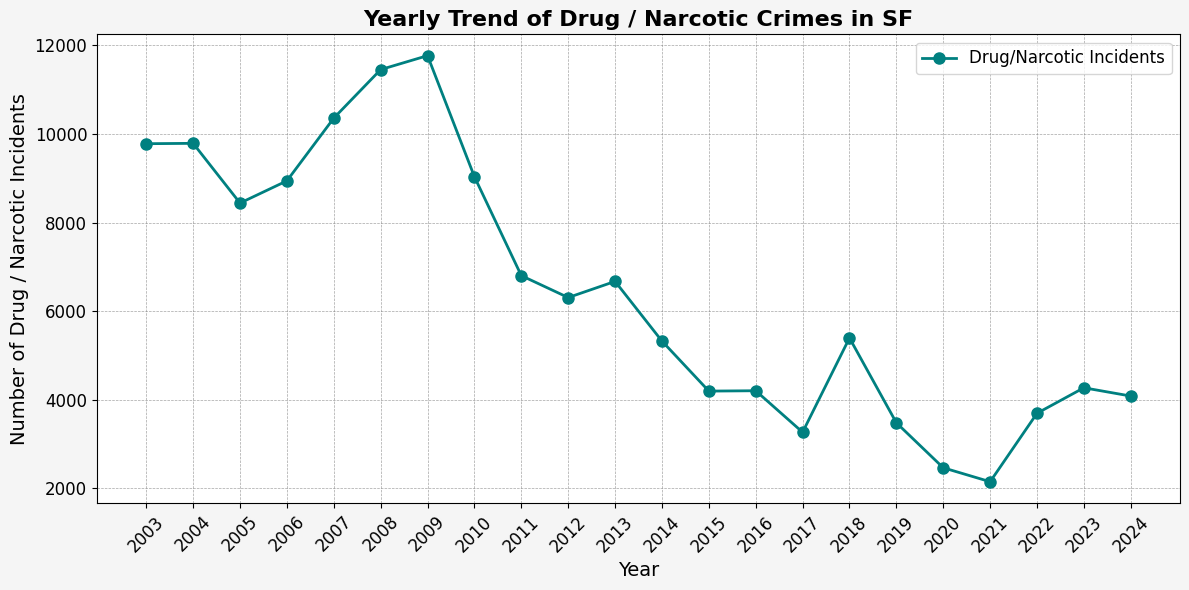

In [131]:
df_drugs['Year'] = df_drugs['Date'].dt.year
yearly_counts = df_drugs.groupby('Year').size().reset_index(name='Count')

yearly_counts = yearly_counts[yearly_counts['Year'] != 2025]

# 2) Plot
plt.figure(figsize=(12, 6), facecolor='whitesmoke')  # Set a light background color
plt.plot(yearly_counts['Year'], yearly_counts['Count'], marker='o', linestyle='-', color='teal', markersize=8, linewidth=2, label='Drug/Narcotic Incidents')
plt.title("Yearly Trend of Drug / Narcotic Crimes in SF", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Drug / Narcotic Incidents", fontsize=14)
plt.xticks(yearly_counts['Year'], rotation=45, fontsize=12)  # Set x-ticks to show each year diagonally
plt.yticks(fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Lighter grid lines
plt.legend(fontsize=12)  # Add legend
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig("drug_narcotic_crimes_per_year.png")
plt.show()

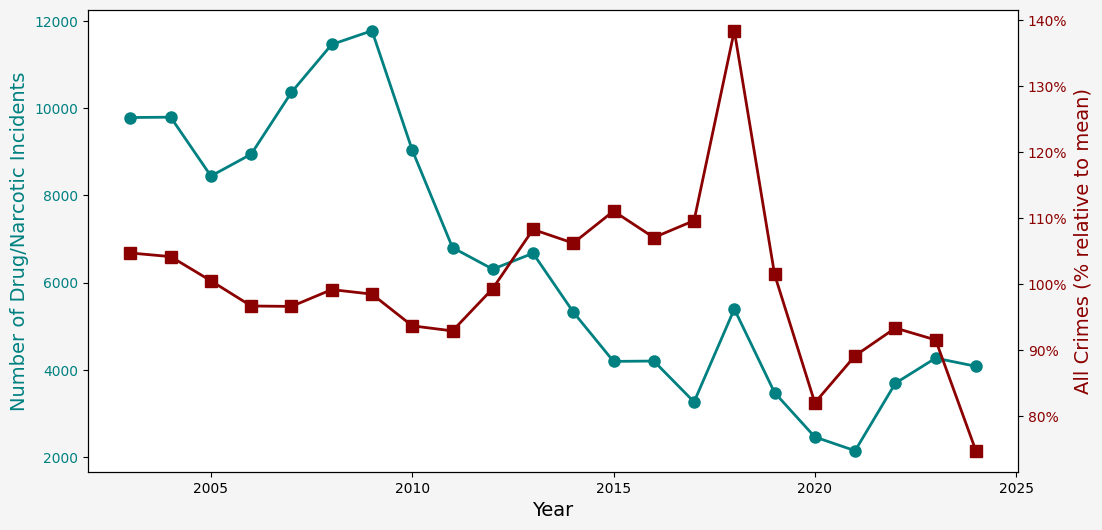

In [ ]:
# Import required libraries (if not already imported)
import pandas as pd
import matplotlib.pyplot as plt

# Calculate drug crimes yearly counts
df_drugs['Year'] = df_drugs['Date'].dt.year
drug_yearly_counts = df_drugs.groupby('Year').size().reset_index(name='Drug_Count')
drug_yearly_counts = drug_yearly_counts[drug_yearly_counts['Year'] != 2025]

# Calculate all crimes yearly counts
df['Year'] = df['Date'].dt.year
all_yearly_counts = df.groupby('Year').size().reset_index(name='All_Count')
all_yearly_counts = all_yearly_counts[all_yearly_counts['Year'] != 2025]

# Normalize all crimes relative to drug crimes (set same scale)
all_yearly_counts['Normalized'] = (all_yearly_counts['All_Count'] / all_yearly_counts['All_Count'].mean()) * drug_yearly_counts['Drug_Count'].mean()

# ... existing code ...

# Calculate the percentage relative to mean for all crimes
all_yearly_counts['Relative_Percentage'] = (all_yearly_counts['All_Count'] / all_yearly_counts['All_Count'].mean() * 100)

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6), facecolor='whitesmoke')

# Plot drug crimes on primary y-axis
ax1.plot(drug_yearly_counts['Year'], drug_yearly_counts['Drug_Count'], 
         marker='o', linestyle='-', color='teal', markersize=8, linewidth=2, 
         label='Drug/Narcotic Incidents')
ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("Number of Drug/Narcotic Incidents", fontsize=14, color='teal')
ax1.tick_params(axis='y', labelcolor='teal')

# Create secondary y-axis and plot all crimes
ax2 = ax1.twinx()
ax2.plot(all_yearly_counts['Year'], all_yearly_counts['Relative_Percentage'], 
         marker='s', linestyle='-', color='darkred', markersize=8, linewidth=2, 
         label='All Crimes (% of Mean)')
ax2.set_ylabel("All Crimes (% relative to mean)", fontsize=14, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

# Add percentage signs to right y-axis
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x)}%'))


Generally we see that the amount of reported  prostitution has been on a decline in the SF area from 2003 till now. 

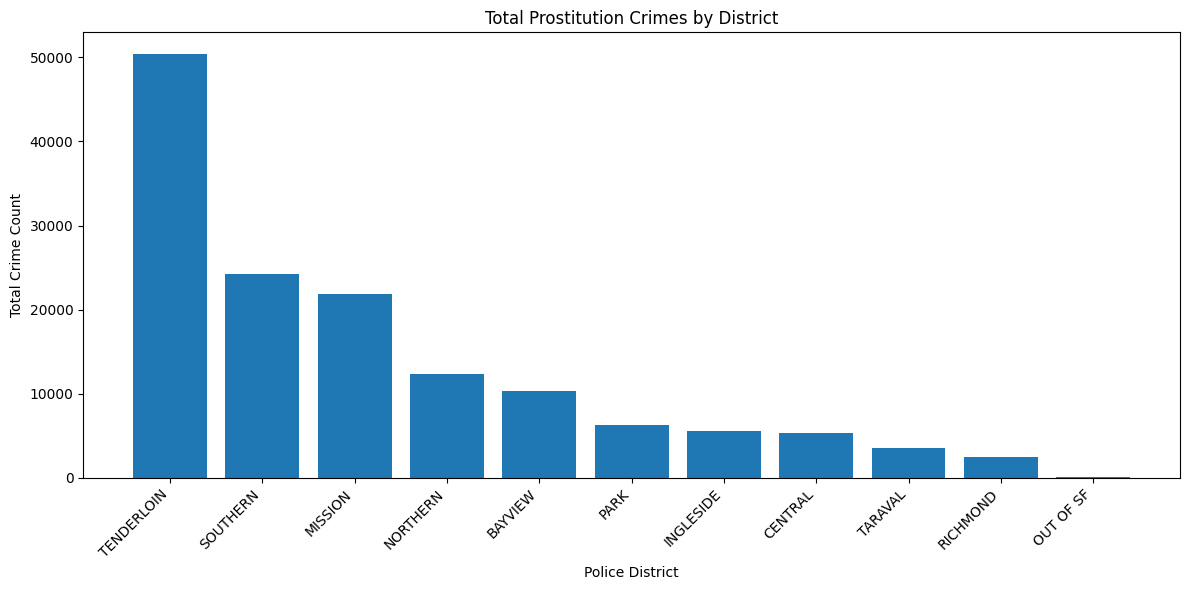

In [130]:
# Group by Police District and sum the total crime counts
district_total = df_drugs.groupby('PoliceDistrict').size().reset_index(name='Total Count')

# Sort by count for better visualization
district_total = district_total.sort_values(by='Total Count', ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(district_total['PoliceDistrict'], district_total['Total Count'])
plt.title("Total Prostitution Crimes by District")
plt.xlabel("Police District")
plt.ylabel("Total Crime Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Looking at the accumulated reported prostitution by district, we see that the arrests are heavily screwed toward some districts. District "Mission" seam to be a hotspot, and the three runner-ups "Northern", "Tenderloin" & "Central" also have noticeably more arrests than the rest. 

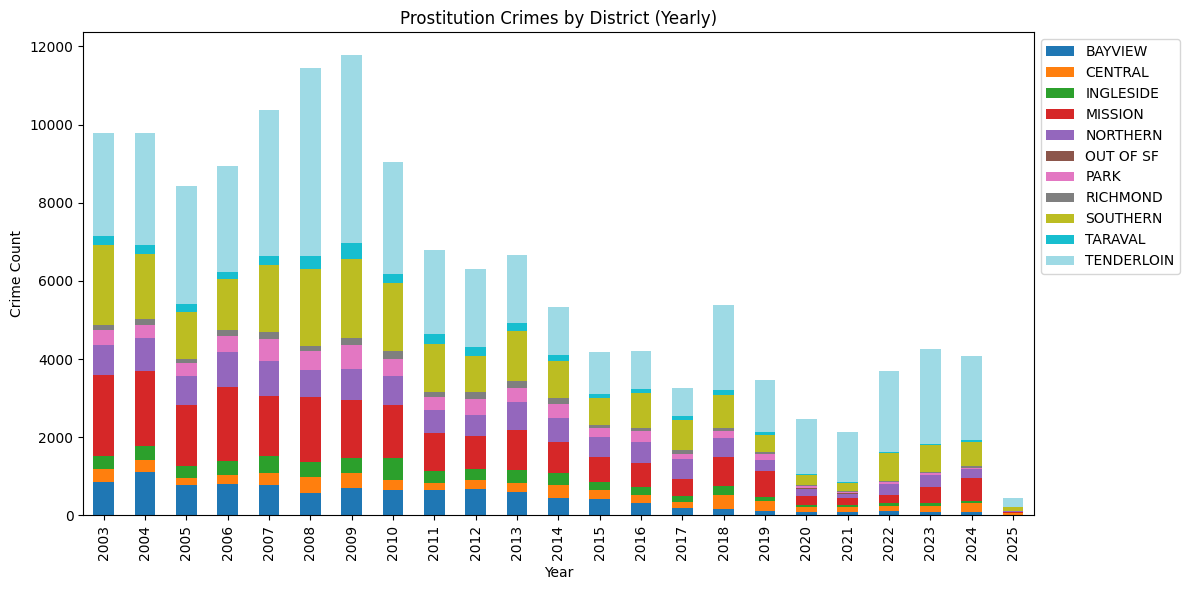

In [123]:
# Ensure PoliceDistrict column has no NaN values
df_drugs['PoliceDistrict'] = df_drugs['PoliceDistrict'].fillna("UNKNOWN")

# Extract year from the Date column
df_drugs['Year'] = df_drugs['Date'].dt.year

# Group by Year and Police District
yearly_district = df_drugs.groupby(['Year', 'PoliceDistrict']).size().reset_index(name='Count')

# Pivot table for easier plotting
district_pivot = yearly_district.pivot(index='Year', columns='PoliceDistrict', values='Count').fillna(0)

# Plot stacked bar chart
district_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title("Prostitution Crimes by District (Yearly)")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


Looking at the trends over the years, we see that it is more or less the same districts as mentioned earlier that dominates the reports each year.  

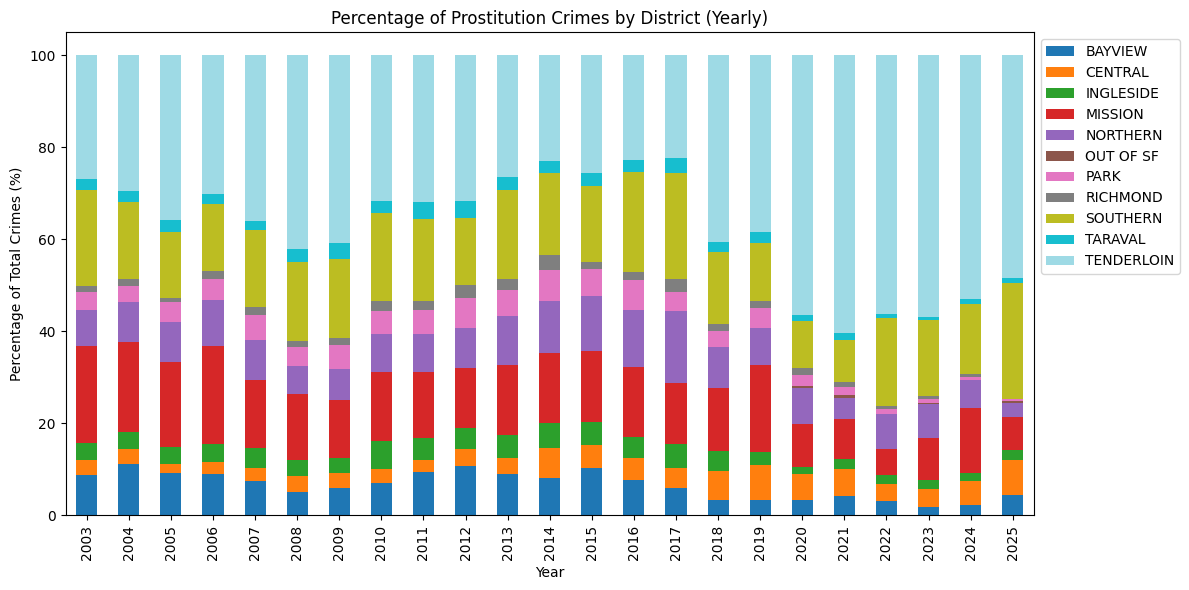

In [124]:
# Group by Year and Police District to get total counts
yearly_district = df_drugs.groupby(['Year', 'PoliceDistrict']).size().reset_index(name='Count')

# Calculate total prostitution cases per year
yearly_total = df_drugs.groupby('Year').size().reset_index(name='Total')

# Merge with yearly_district to get percentage
yearly_district = yearly_district.merge(yearly_total, on='Year')
yearly_district['Percentage'] = (yearly_district['Count'] / yearly_district['Total']) * 100

# Pivot table for easier plotting
district_pivot = yearly_district.pivot(index='Year', columns='PoliceDistrict', values='Percentage').fillna(0)

# Plot stacked bar chart
district_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title("Percentage of Prostitution Crimes by District (Yearly)")
plt.xlabel("Year")
plt.ylabel("Percentage of Total Crimes (%)")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

Looking at this plot we see the amount of the total prostitution was reported in the individual districts. We see a clear trend over the last couple years, that the prostitution has moved into one specific area namely the "Mission" district.

### Map over the SF Police Disstricts 
Before looking at our data on the map we look at the actual placement of the individual PD's:
![Image](https://lh4.googleusercontent.com/-SVEsrsxL318/VKCIq3U8lfI/AAAAAAAAbug/REilUPI6NxI/s960/SFPDdistricts2.jpg)

In [133]:
# Group the prostitution crimes by Year
year_groups = df_drugs.groupby("Year")

heatmap_data = []
time_labels = []

# For each year collect ["Latitude", "Longitude"] pairs
for year, group in year_groups:
    if year == 2025:  # Skip the year 2025
        continue
    lat_lon_pairs = group[["Latitude", "Longitude"]].values.tolist()
    heatmap_data.append(lat_lon_pairs)
    time_labels.append(str(year))  
    
# Initialize Folium map around SF
m = folium.Map(location=[37.7749, -122.4194], zoom_start=13)

# Add a time-lapse heatmap
HeatMapWithTime(
    data=heatmap_data,
    index=time_labels,
    radius=15,       
    auto_play=True, 
    max_opacity=0.7  
).add_to(m)

# Save or display
m.save("drug_n_narcotics_heatmap_by_year.html")
m

Looking at this heatmap we see that there are two main hotspots that stay more or less the same over the years. The first one is located in the "Mission" district and the other is on the intersection between the three districts "Northern", "Tenderloin" & "Central". 

This explains why we saw by far the most repports in "Mission" and a smaller but still great amount of reports from "Northern", "Tenderloin" & "Central". 

We see that over the years the general prostitution has gone down. The "northern hotspot" has basically disappeared and (as we can also see in the "Percentage of Prostitution Crimes by District (Yearly)" graf) from 2023, 85% or more of the reported prostitution came from "Mission".

## Use of AI in This Project
Artificial Intelligence has been in multiple aspects of this project. AI tools were used to clean up and improve readability with comments. 
Additionally, AI provided guidance on methodological approaches to ensure better practise were followed. A key contribution was in the data wrangling part, where AI transformed and aligning datasets to accurate match parts of the two datasets. 

## Contributions
All three team members contributed across all five parts of the project. All members have completed the weekly exercises need for this project. The final result is a combination of different approaches, reflecting the work of individual efforts into the resulting outcome.

In [126]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Parameters
N_CLUSTERS = 2  # Number of clusters

# Step 1: Prepare the data
hourly_crime_counts = df.groupby(['Category', 'Hour']).size().unstack(fill_value=0)

# Step 2: Compute total crimes per category
total_crimes = hourly_crime_counts.sum(axis=1)

# Step 3: Compute proportion of crimes per hour
crime_distribution = hourly_crime_counts.div(total_crimes, axis=0)

# Step 4: Remove categories with no variation
valid_categories = crime_distribution.loc[crime_distribution.std(axis=1) > 0]

# Explicitly drop any categories with zero total crimes (redundant safety check)
valid_categories = valid_categories.loc[total_crimes > 0]

# Exclude TREA category if present
valid_categories = valid_categories.drop(index="TREA", errors="ignore")

if valid_categories.empty:
    print("No valid categories found after filtering.")
else:
    # Step 5: Standardize the data
    scaler = StandardScaler()
    crime_scaled = scaler.fit_transform(valid_categories)

    # Step 6: Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    crime_pca = pca.fit_transform(crime_scaled)

    # Step 7: Apply KMeans clustering
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
    kmeans.fit(crime_pca)

    # Step 8: Assign clusters to crime categories
    clustered_df = pd.DataFrame({'Category': valid_categories.index, 'Cluster': kmeans.labels_})

    # Step 9: Compute weighted average proportion of crimes per hour per cluster
    cluster_avg = pd.DataFrame(index=range(24))
    
    for cluster in range(N_CLUSTERS):
        cluster_categories = clustered_df.loc[clustered_df['Cluster'] == cluster, 'Category']
        
        if cluster_categories.empty:
            # Avoid empty clusters causing NaN issues
            cluster_avg[cluster] = 0
            continue
        
        # Extract relevant crime data
        cluster_data = crime_distribution.loc[cluster_categories]
        cluster_weights = total_crimes.loc[cluster_categories]  # Weights based on total crimes
        
        # Compute weighted mean instead of simple mean
        cluster_avg[cluster] = np.average(cluster_data, axis=0, weights=cluster_weights)

    # Step 10: Compute total proportion of crimes per cluster
    cluster_totals = cluster_avg.sum()

    # Step 11: Plot crime distribution and total proportions per cluster
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot crime distribution per cluster
    for cluster in range(N_CLUSTERS):
        ax1.plot(cluster_avg.index, cluster_avg[cluster], label=f'Cluster {cluster}')

    # Set dynamic y-limit based on max value
    max_y_value = cluster_avg.max().max() * 1.1
    ax1.set_ylim(0, max_y_value)

    # Labels and grid
    ax1.set_title('Crime Patterns by Hour and Cluster')
    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Weighted Average Proportion of Crimes')
    ax1.set_xticks(range(24))
    ax1.legend(loc='upper left')
    ax1.grid()

    plt.tight_layout()
    plt.show()

    # Print clusters
    for cluster in range(N_CLUSTERS):
        print(f"Cluster {cluster}:")
        print(clustered_df.loc[clustered_df['Cluster'] == cluster, 'Category'].tolist())
        print()


KeyError: 'Hour'

Index(['IncidentNumber', 'IncidentCode', 'Category', 'Subcategory', 'Date',
       'Time', 'PoliceDistrict', 'Resolution', 'Year', 'Longitude', 'Latitude',
       'Month', 'Hour', 'Minute', 'CrimeHour'],
      dtype='object')


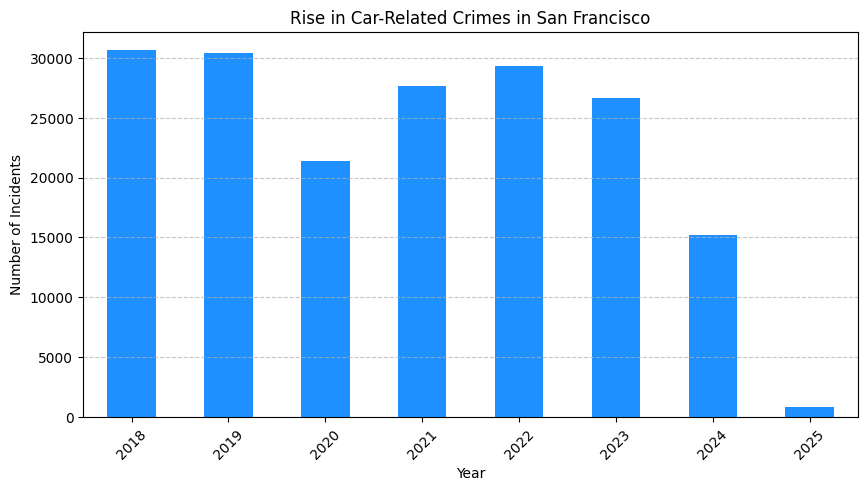

Index(['IncidentNumber', 'IncidentCode', 'Category', 'Subcategory', 'Date',
       'Time', 'PoliceDistrict', 'Resolution', 'Year', 'Longitude', 'Latitude',
       'Month', 'Hour', 'Minute', 'CrimeHour'],
      dtype='object')


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_file

# Check the column names in the DataFrame
print(df.columns)

# Filter car-related crimes
car_crimes = df[df['Category'].isin(["LARCENY/THEFT", "VEHICLE THEFT"])]
car_crimes = car_crimes[car_crimes['Subcategory'].isin(["LARCENY - FROM VEHICLE", "MOTOR VEHICLE THEFT"])]

# ------------------ Time-Series Visualization ------------------
plt.figure(figsize=(10, 5))

# Check if 'IncidntNum' exists, if not, use an appropriate column name
if 'IncidntNum' in car_crimes.columns:
    car_crimes.groupby(car_crimes['Date'].dt.year)['IncidntNum'].count().plot(kind='bar', color='dodgerblue')
else:
    # If 'IncidntNum' does not exist, use a different column for counting incidents
    car_crimes.groupby(car_crimes['Date'].dt.year).size().plot(kind='bar', color='dodgerblue')

plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.title("Rise in Car-Related Crimes in San Francisco")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ------------------ Crime Hotspot Map ------------------
# Print the column names to find the correct latitude and longitude columns
print(car_crimes.columns)

# Replace 'Y' and 'X' with the actual names of the latitude and longitude columns
latitude_col = 'Latitude'  # Change this to the actual name of the latitude column
longitude_col = 'Longitude'  # Change this to the actual name of the longitude column

# Create heatmap data
heat_data = car_crimes[[latitude_col, longitude_col]].dropna().values.tolist()
crime_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)
HeatMap(heat_data, radius=8, blur=5).add_to(crime_map)

# Display the map in the notebook
crime_map

# Optionally, save the map as HTML
# crime_map.save("sf_car_crime_map.html")  # Uncomment to save as HTML

# ------------------ Interactive Bokeh Visualization ------------------
car_crimes['Hour'] = car_crimes['Date'].dt.hour
hourly_counts = car_crimes.groupby('Hour').size().reset_index(name='IncidntNum')

output_file("sf_car_crime_bokeh.html")  # Save the output to an HTML file
source = ColumnDataSource(hourly_counts)
p = figure(title="Car-Related Crimes by Hour", x_axis_label="Hour of the Day", y_axis_label="Number of Incidents", width=800, height=400)
p.vbar(x='Hour', top='IncidntNum', source=source, width=0.5, color='firebrick')
p.add_tools(HoverTool(tooltips=[("Hour", "@Hour"), ("Incidents", "@IncidntNum")]))
show(p)

/var/folders/1h/fbz069916kvd8trkfrmhx0fr0000gn/T/ipykernel_69525/1678711823.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drug_narcotic['Year'] = df_drug_narcotic['Date'].dt.year


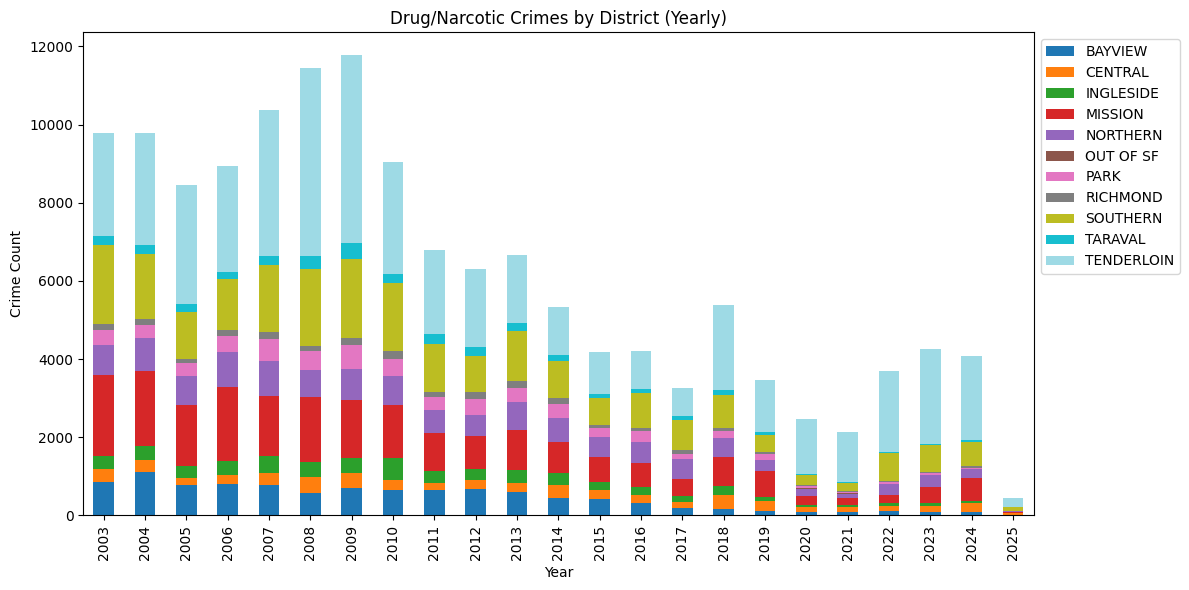

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Ensure PoliceDistrict column has no NaN values
df['PoliceDistrict'] = df['PoliceDistrict'].fillna("UNKNOWN")

# Filter for Drug/Narcotic crimes only
df_drug_narcotic = df[df['Category'] == "DRUG/NARCOTIC"]

# Extract year from the Date column
df_drug_narcotic['Year'] = df_drug_narcotic['Date'].dt.year

# Group by Year and Police District
yearly_district_drug = df_drug_narcotic.groupby(['Year', 'PoliceDistrict']).size().reset_index(name='Count')

# Pivot table for easier plotting
district_pivot_drug = yearly_district_drug.pivot(index='Year', columns='PoliceDistrict', values='Count').fillna(0)

# Plot stacked bar chart for Drug/Narcotic crimes
district_pivot_drug.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title("Drug/Narcotic Crimes by District (Yearly)")
plt.xlabel("Year")
plt.ylabel("Crime Count")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("drug_narcotic_crimes_by_district.png")  # Save the figure as a PNG file
plt.show()

In [ ]:
import folium
from folium.plugins import HeatMapWithTime

# Filter for Drug/Narcotic crimes only
df_drug_narcotic = df[df['Category'] == "DRUG/NARCOTIC"]

# Filter out rows where latitude or longitude are missing
df_drug_narcotic = df_drug_narcotic.dropna(subset=['Latitude', 'Longitude'])

# Group the drug/narcotic crimes by Year
year_groups = df_drug_narcotic.groupby("Year")

heatmap_data = []
time_labels = []

# For each year collect ["Latitude", "Longitude"] pairs
for year, group in year_groups:
    lat_lon_pairs = group[["Latitude", "Longitude"]].values.tolist()
    heatmap_data.append(lat_lon_pairs)
    time_labels.append(str(year))

# Initialize Folium map around SF
m = folium.Map(location=[37.7749, -122.4194], zoom_start=13)

# Add a time-lapse heatmap for drug/narcotic crimes
HeatMapWithTime(
    data=heatmap_data,
    index=time_labels,
    radius=15,       
    auto_play=True, 
    max_opacity=0.7  
).add_to(m)

# Save the map to an HTML file
map_filename = "drug_narcotic_heatmap_by_year.html"
m.save(map_filename)

# To view the map, open the generated HTML file in your browser
print(f"Map saved to {map_filename}")

Map saved to drug_narcotic_heatmap_by_year.html


In [ ]:
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20
from bokeh.layouts import column
from bokeh.io import push_notebook
from bokeh.transform import cumsum

# Filter data for drug/narcotic crimes and group by year and police district
df_drug_narcotic = df[df['Category'] == "DRUG/NARCOTIC"]

# Group data by year and police district
yearly_district_drug = df_drug_narcotic.groupby(['Year', 'PoliceDistrict']).size().reset_index(name='Count')

# Pivot table for easier plotting
district_pivot_drug = yearly_district_drug.pivot(index='Year', columns='PoliceDistrict', values='Count').fillna(0)

# Reset the index without duplicating the 'Year' column
district_pivot_drug_reset = district_pivot_drug.reset_index()

# Melt the data to long format
district_pivot_drug_melted = district_pivot_drug_reset.melt(id_vars=['Year'], var_name='PoliceDistrict', value_name='Count')

# Create a ColumnDataSource
source = ColumnDataSource(district_pivot_drug_melted)

# Create Bokeh plot
p = figure(x_range=district_pivot_drug_melted['Year'].unique().tolist(), plot_height=400, title="Drug/Narcotic Crimes by District (Yearly)",
           toolbar_location=None, tools="hover", tooltips="@PoliceDistrict: @Count", sizing_mode="scale_width")

p.vbar(x='Year', top='Count', width=0.9, source=source, legend_field="PoliceDistrict", line_color="white", fill_color=factorize('PoliceDistrict', Category20[20]))

# Formatting
p.xaxis.major_label_orientation = "vertical"
p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Crime Count"
p.legend.title = "Police District"
p.legend.orientation = "horizontal"
p.legend.location = "top_left"

# Show plot
output_file("sf_drug_crimes_interactive.html")
show(p, notebook_handle=True)


ValueError: failed to validate FigureOptions(...).x_range: expected an element of either Instance(Range), Tuple(Float, Float), Tuple(Datetime, Datetime), Tuple(TimeDelta, TimeDelta), Seq(String), EagerSeries or PandasGroupBy, got [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]